In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from tqdm import tqdm


font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

In [2]:
# System parameters
kB    = 0.008314463 # kJ mol-1 K
T     = 300         # K
mass  = 1           # amu
beta  = 1 / kB / T
print(beta)

0.4009078317304838


In [3]:
# Initialize the variables x and y for symbolic calculation
x   =  sp.symbols('x')

# Define the potentials Va, Vb and V with sympy
V   = ( x ** 2 - 1 ) ** 2

# Calculate derivative and second derivative with sympy
gradVx   =  V.diff(x)
grad2Vx2 =  gradVx.diff(x)

# To display sympy functions:
# display(gradVx)

# Convert potential and derivatives in numpy functions
V         =  sp.lambdify((x), V, modules=['numpy'])
gradVx    =  sp.lambdify((x), gradVx, modules=['numpy'])
grad2Vx2  =  sp.lambdify((x), grad2Vx2, modules=['numpy'])

In [4]:
# Grid
xbins     = 500   
xmin      = - 3.5
xmax      = - xmin
xedges    = np.linspace(xmin, xmax, xbins)  # array with x edges
dx        = xedges[1] - xedges[0]
xcenters  = xedges[:-1] + (dx / 2)                # array with x centers
xbins     = xbins - 1

iA        = np.argmin(V(xcenters[0:int(xbins/2)]))
iC        = int(xbins/2) + np.argmin(V(xcenters[int(xbins/2):-1]))
iB        = iA   + np.argmax(V(xcenters[iA:iC]))

print(xcenters[iA])
print(xcenters[iC])
print(xcenters[iB])

# Approximation at xA and xB
xA        = xcenters[iA]
omegaA    = np.sqrt( np.abs(grad2Vx2(xA)) / mass )
kspringA  = omegaA ** 2 * mass

xB        = xcenters[iB]
omegaB    = np.sqrt( np.abs(grad2Vx2(xB)) / mass )
kspringB  = omegaB ** 2 * mass

xC        = xcenters[iC]
omegaC    = np.sqrt( np.abs(grad2Vx2(xC)) / mass )
kspringC  = omegaC ** 2 * mass

# Energy barriers
Eb_plus   = V(xB) - V(xA)
Eb_minus  = V(xB) - V(xC)

-0.9959919839679359
0.9959919839679359
-2.220446049250313e-16


The next block defines the BBK integrator for Langevin dynamics.

In [5]:
def langevin_bbk_step(Q, P, M, gamma, beta, der_V, dt):
    L = 1 / (1 + 0.5 * gamma*dt)
    
    # Deterministic force
    F  =  - der_V(Q)
    
    # Random force 
    R  =  np.random.normal(0, 1, size = np.array(Q).shape)
    
    # update p_{n+1/2}
    Phalf = ( 1 - 0.5 * gamma * dt ) * P + 0.5 * F * dt + 0.5 * np.sqrt( 2 / beta * dt * gamma * M ) * R
    
    # update q_{n+1}
    Q  =  Q + Phalf / M * dt
    
    # Recalculate deterministic force (but not the random force)
    F  =  - der_V(Q)
    
    # update p_{n+1}
    P = ( Phalf + 0.5 * F * dt + 0.5 * np.sqrt( 2 / beta * dt * gamma * M ) * R ) / ( 1 + 0.5 * gamma * dt ) 

    return Q, P

In [6]:
# Number of gamma values being test
Ng     = 30 #25

# Generate gamma values between 0.05 and 10
# Use logspace to generate more points close to 0.05 than 10
gammas =  np.logspace(np.log(0.01), np.log(25), Ng, base=np.exp(1))

### Numerical experiment

In [7]:
# Number of simulations
Nreps = 500

# Integrator timestep
dt  =  0.005 # ps
sdt =  np.sqrt(dt)

# Array to store simulation time for each replica and each gamma value
simTimes = np.zeros((Nreps,Ng))

# For loop over gamma values
for g, gamma in enumerate(gammas):
    
    print("Gamma: ", str(gamma))
          
    # Recalculate diffusion constant
    D     = kB * T / mass / gamma # nm2 ps-1
    sigma = np.sqrt(2 * D)

    for r in range(Nreps):
        
        #print("Gamma: ", str(gamma), "; Replica: ", str(r))
        
        # Initial position
        x0  =  xA 

        # Final position
        xF  =  xC
        
        # Initial momentum drawn from the Boltzmann distribution
        p0  =  np.random.normal(0, 1) * np.sqrt( mass / beta )

        # Initialize position and velocity
        x   =   x0
        v   =   p0 / mass
        
        t = 0
        
        # Start the simulation and stop if x > xC
        while x < xF:
            
            # Update position and momentum
            x, p = langevin_bbk_step(x, mass * v, mass, gamma, beta, gradVx, dt)
            
            # Calculate velocity
            v    = p / mass
            
            # Update simulation time
            t    = t + 1
        
        # Store simulation time to go from xA to xB
        simTimes[r,g] = t * dt
            
    
# MFPT from experiment
MFPT = np.mean(simTimes, axis=0)

# Rate from experiment
expRate = 1 / MFPT    

Gamma:  0.010000000000000007
Gamma:  0.013096955295775894
Gamma:  0.017153023801955224
Gamma:  0.02246523859215873
Gamma:  0.029422622555044218
Gamma:  0.03853467722879015
Gamma:  0.05046869450026176
Gamma:  0.06609862357060987
Gamma:  0.08656907180165961
Gamma:  0.11337912633831491
Gamma:  0.14849213491270372
Gamma:  0.1944794852726002
Gamma:  0.254708912456075
Gamma:  0.33359112398729096
Gamma:  0.436902803792918
Gamma:  0.5722096489874995
Gamma:  0.7494204192600892
Gamma:  0.9815125728791008
Gamma:  1.2854826289239565
Gamma:  1.6835908524513516
Gamma:  2.2049914130932584
Gamma:  2.8878673964852104
Gamma:  3.7822270191895493
Gamma:  4.953565818880125
Gamma:  6.4876630084556455
Gamma:  8.496863239580248
Gamma:  11.128303800310405
Gamma:  14.574689739047827
Gamma:  19.08840599621129
Gamma:  24.99999999999999


## Pontryagin formula

In [8]:
def pontryagin_mfpt( gamma, beta, V, x0, xF, xcenters ):

    D = 1 / beta / mass / gamma
    
    i0 = np.argmin(np.abs(xcenters - x0)) + 1
    xcenters0 = xcenters[0:i0]
    
    iF = np.argmin(np.abs(xcenters - xF)) + 1
    xcentersF = xcenters[0:iF]
    
    nn = iF - i0
    innerInt = np.zeros(nn+1)
    
    for i in range(nn):
        x = xcenters[0:iA+i+1]
        innerInt[i+1] = np.sum(dx * np.exp( - beta * V(x) ) )

    x        = xcenters[iA:iA+i+2]
    outerInt = sum( dx * np.exp(beta * V(x)) * innerInt )

    mfpt = outerInt / D

    return mfpt

exactRates = np.zeros(Ng)

for g, gamma in enumerate(gammas):
    exactRates[g] = 1 / pontryagin_mfpt( gamma, beta, V, x0, xF, xcenters )

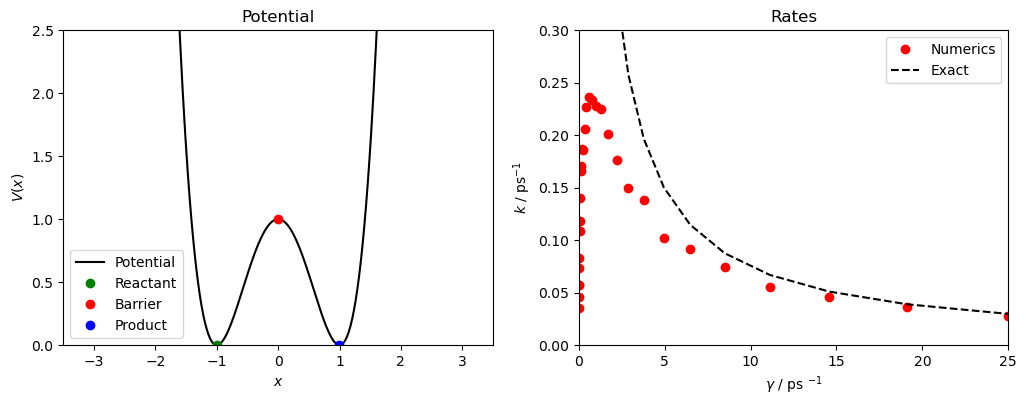

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24*in2cm, 8*in2cm), facecolor='white')  

ax1.plot(xcenters, V(xcenters), 'k', label = 'Potential') 
#ax1.plot(xcenters,   0.5 * kspringA * (xcenters - xA) ** 2 + V(xA), 'k--', linewidth = 0.5, label = 'Harmonic approximation') 
ax1.plot(xA, V(xA), 'go', label = 'Reactant') 

#ax1.plot(xcenters, - 0.5 * kspringB * (xcenters - xB) ** 2 + V(xB), 'k--', linewidth = 0.5)
ax1.plot(xB, V(xB), 'ro', label = 'Barrier') 

#ax1.plot(xcenters,   0.5 * kspringC * (xcenters - xC) ** 2 + V(xC), 'k--', linewidth = 0.5 ) 
ax1.plot(xC, V(xC), 'bo' , label = 'Product') 

ax1.set_title('Potential')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$V(x)$')
ax1.legend()
ax1.set_ylim((-0, 2.5))
ax1.set_xlim((xmin, xmax))


ax2.plot(gammas, expRate, 'ro', label = 'Numerics') 
#ax1.plot(xcenters,   0.5 * kspringA * (xcenters - xA) ** 2 + V(xA), 'k--', linewidth = 0.5, label = 'Harmonic approximation') 
ax2.plot(gammas, exactRates, 'k--', label = 'Exact') 

ax2.set_title('Rates')
ax2.set_xlabel(r'$\gamma$ / ps $^{-1}$')
ax2.set_ylabel(r'$k$ / ps$^{-1}$')
ax2.legend()
ax2.set_xlim((0, gammas[-1]))
ax2.set_ylim((0, 0.3))

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.4);

#fig.savefig('figures/potential.png', format='png', dpi=900, bbox_inches='tight')